In [1]:
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize, LogNorm
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import scqubits
from tqdm import tqdm
from IPython.display import clear_output
from functools import partial
import matplotlib
from CoupledQuantumSystems.IFQ import gfIFQ

from CoupledQuantumSystems.noise import first_order_derivative,second_order_derivative,get_fluxonium_frequency_with_2pi,diel_spectral_density,one_over_f_spectral_density,T_phi

In [12]:
EJ = 3
EC = EJ/4
EL = EJ/20.5

In [94]:
3/20.5

0.14634146341463414

In [53]:
import pickle
filename = "ef_against_EC.pkl"
EC_arr = np.linspace(0.4,2,100)
phi_element_arr = []
curvature_arr = []
frequency_arr = []
# for EC in tqdm(EC_arr,desc='sweeping'):
#     qbt = gfIFQ(EJ = EJ,EC = EC, EL = EL, flux = 0,truncated_dim=20)
#     phi_element_arr.append(np.abs(qbt.fluxonium.matrixelement_table('phi_operator',evals_count=3)[1,2]) )
#     evals = qbt.fluxonium.eigenvals()
#     frequency_arr.append(2*np.pi*(evals[2]-evals[1]))
#     curvature_arr.append(second_order_derivative(partial(get_fluxonium_frequency_with_2pi, EJ = EJ,EC = EC,EL=EL,i=1,j=2,truncated_dim=20),x0=0,max_iter=40))


# with open(filename, 'wb') as f:
#     pickle.dump((phi_element_arr, curvature_arr, frequency_arr), f)

with open(filename, 'rb') as f:
    phi_element_arr, curvature_arr, frequency_arr = pickle.load(f)

phi_element_arr = np.array(phi_element_arr)
frequency_arr = np.array(frequency_arr)
curvature_arr = np.array(curvature_arr)

Q_cap = 1e5
one_over_f_flux_noise_amplitude = 1e-5
temp_in_mK=20

dielectric_lifetime = 1 / (np.abs(phi_element_arr)**2 * diel_spectral_density(frequency_arr, EC_arr,temp_in_mK,Q_cap)) / 1e6
one_over_f_loss_lifetime = 1 / (np.abs(phi_element_arr)**2 * one_over_f_spectral_density(frequency_arr, EL,one_over_f_flux_noise_amplitude ))  / 1e6
dephasing_lifetime = T_phi(curvature_arr, one_over_f_flux_noise_amplitude) / 1e6

T1 =1/(1/dielectric_lifetime + 1/one_over_f_loss_lifetime)
T2 = 1/ (1/(2*T1) + 1/dephasing_lifetime)

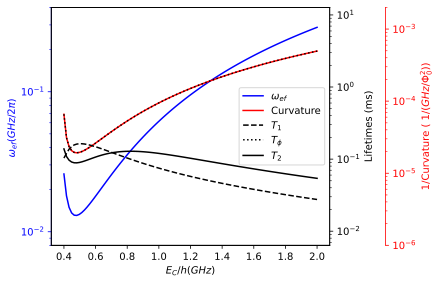

In [54]:
fig, ax_freq_EC = plt.subplots(figsize=(5, 4.3))
ax_freq_EC.plot(EC_arr,frequency_arr/2/np.pi,color='blue')
ax_freq_EC.tick_params(axis='y', colors=ax_freq_EC.get_lines()[0].get_color())
ax_freq_EC.yaxis.label.set_color(ax_freq_EC.get_lines()[0].get_color())
ax_freq_EC.tick_params(axis='y', which='both', colors=ax_freq_EC.get_lines()[0].get_color())
ax_freq_EC.spines['left'].set_color(ax_freq_EC.get_lines()[0].get_color())

ax_freq_EC.set_ylim(8e-3,4e-1)
ax_freq_EC.set_xlabel(rf"$E_C/h (GHz)$")
ax_freq_EC.set_ylabel(rf"$\omega_{{ef}} (GHz/2\pi)$ ")
ax_freq_EC.set_yscale('log')

ax_curvature_EC = ax_freq_EC.twinx()
ax_curvature_EC.spines.right.set_position(("axes", 1.2))
ax_curvature_EC.plot(EC_arr,1/curvature_arr,color='red')
ax_curvature_EC.yaxis.label.set_color(ax_curvature_EC.get_lines()[0].get_color())
ax_curvature_EC.tick_params(axis='y', which='both', colors=ax_curvature_EC.get_lines()[0].get_color())
ax_curvature_EC.spines['right'].set_color(ax_curvature_EC.get_lines()[0].get_color())
ax_curvature_EC.set_ylabel(r'1/Curvature ( $1/(GHz/\Phi_0^2)$)') 
ax_curvature_EC.set_ylim(1e-6,2e-3)
ax_curvature_EC.set_yscale('log')


ax_lifetime_EC = ax_freq_EC.twinx()
ax_lifetime_EC.plot([],[],color=ax_freq_EC.get_lines()[0].get_color(),label = rf"$\omega_{{ef}}$")
ax_lifetime_EC.plot([],[],color=ax_curvature_EC.get_lines()[0].get_color(),label = r'Curvature')
ax_lifetime_EC.plot(EC_arr,T1,label = r'$T_{{1}}$',color='black',linestyle='--')
# ax_lifetime.plot(EC_arr,one_over_f_loss_lifetime,label = r'$T_{{1/f}}$',color='black',linestyle=':')
ax_lifetime_EC.plot(EC_arr,dephasing_lifetime,label = r'$T_{{\phi}}$',color='black',linestyle=':')
ax_lifetime_EC.plot(EC_arr,T2,label = r'$T_{{2}}$',color='black',linestyle='-')
ax_lifetime_EC.set_ylabel(r'Lifetimes (ms)')
ax_lifetime_EC.set_yscale('log')
ax_lifetime_EC.legend(loc='center right')
dephasing_min = dephasing_lifetime.min()
dephasing_max = dephasing_lifetime.max()
curvature_y_data = ax_curvature_EC.get_lines()[0].get_ydata()
curvature_y_min = curvature_y_data.min()
curvature_y_max = curvature_y_data.max()
curvature_ylim_min = ax_curvature_EC.get_ylim()[0]
curvature_ylim_max = ax_curvature_EC.get_ylim()[1]
dp_length_log_scale = abs(np.log10(dephasing_max) - np.log10(dephasing_min))
curvature_ylim_length_log_scale = abs(np.log10(curvature_ylim_max) - np.log10(curvature_ylim_min))
curvature_y_length_log_scale = abs(np.log10(curvature_y_max) - np.log10(curvature_y_min))
dq_ylim_length_log_scale = dp_length_log_scale * curvature_ylim_length_log_scale / curvature_y_length_log_scale
curvature_ymin_ratio = np.abs(np.log10(curvature_y_min)-np.log10(curvature_ylim_min))  / np.abs(np.log10(curvature_ylim_max)-np.log10(curvature_ylim_min))
dq_ylim_min_log_scale = np.log10(dephasing_min) - dq_ylim_length_log_scale * curvature_ymin_ratio
dq_ylim_max_log_scale = dq_ylim_min_log_scale + dq_ylim_length_log_scale
dq_ylim_min = 10**dq_ylim_min_log_scale
dq_ylim_max = 10**dq_ylim_max_log_scale
ax_lifetime_EC.set_ylim(dq_ylim_min, dq_ylim_max)
ax_lifetime_EC.set_yscale('log')


In [57]:
import pickle
filename = "ef_against_EL.pkl"
EL_arr = np.linspace(0.06,0.2,100)
# phi_element_arr = []
# curvature_arr = []
# frequency_arr = []
# for EL in tqdm(EL_arr,desc='sweeping'):
#     qbt = gfIFQ(EJ = EJ,EC = EC, EL = EL, flux = 0,truncated_dim=20)
#     phi_element_arr.append(np.abs(qbt.fluxonium.matrixelement_table('phi_operator',evals_count=3)[1,2]) )
#     evals = qbt.fluxonium.eigenvals()
#     frequency_arr.append(2*np.pi*(evals[2]-evals[1]))
#     curvature_arr.append(second_order_derivative(partial(get_fluxonium_frequency_with_2pi, EJ = EJ,EC = EC,EL=EL,i=1,j=2,truncated_dim=20),x0=0,max_iter=40))

# with open(filename, 'wb') as f:
#     pickle.dump((phi_element_arr, curvature_arr, frequency_arr), f)

with open(filename, 'rb') as f:
    phi_element_arr, curvature_arr, frequency_arr = pickle.load(f)

phi_element_arr = np.array(phi_element_arr)
frequency_arr = np.array(frequency_arr)
curvature_arr = np.array(curvature_arr)

Q_cap = 1e5
one_over_f_flux_noise_amplitude = 1e-5
temp_in_mK=20

dielectric_lifetime = 1 / (np.abs(phi_element_arr)**2 * diel_spectral_density(frequency_arr, EC_arr,temp_in_mK,Q_cap)) / 1e6
one_over_f_loss_lifetime = 1 / (np.abs(phi_element_arr)**2 * one_over_f_spectral_density(frequency_arr, EL,one_over_f_flux_noise_amplitude ))  / 1e6
dephasing_lifetime = T_phi(curvature_arr, one_over_f_flux_noise_amplitude) / 1e6

T1 =1/(1/dielectric_lifetime + 1/one_over_f_loss_lifetime)
T2 = 1/ (1/(2*T1) + 1/dephasing_lifetime)

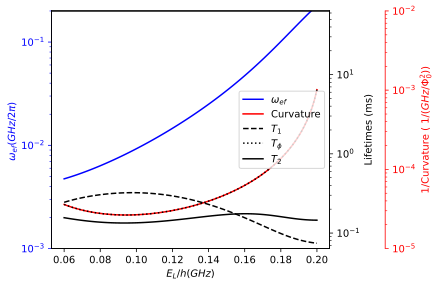

In [58]:
fig, ax_freq_EL = plt.subplots(figsize=(5, 4.3))
ax_freq_EL.plot(EL_arr,frequency_arr/2/np.pi,color='blue')
ax_freq_EL.tick_params(axis='y', colors=ax_freq_EL.get_lines()[0].get_color())
ax_freq_EL.yaxis.label.set_color(ax_freq_EL.get_lines()[0].get_color())
ax_freq_EL.tick_params(axis='y', which='both', colors=ax_freq_EL.get_lines()[0].get_color())
ax_freq_EL.spines['left'].set_color(ax_freq_EL.get_lines()[0].get_color())

ax_freq_EL.set_ylim(1e-3,2e-1)
ax_freq_EL.set_xlabel(rf"$E_L/h (GHz)$")
ax_freq_EL.set_ylabel(rf"$\omega_{{ef}} (GHz/2\pi)$ ")
ax_freq_EL.set_yscale('log')

ax_curvature_EL = ax_freq_EL.twinx()
ax_curvature_EL.spines.right.set_position(("axes", 1.2))
ax_curvature_EL.plot(EL_arr,1/curvature_arr,color='red')
ax_curvature_EL.yaxis.label.set_color(ax_curvature_EL.get_lines()[0].get_color())
ax_curvature_EL.tick_params(axis='y', which='both', colors=ax_curvature_EL.get_lines()[0].get_color())
ax_curvature_EL.spines['right'].set_color(ax_curvature_EL.get_lines()[0].get_color())
ax_curvature_EL.set_ylabel(r'1/Curvature ( $1/(GHz/\Phi_0^2)$)') 
ax_curvature_EL.set_ylim(1e-5,1e-2)
ax_curvature_EL.set_yscale('log')


ax_lifetime_EL = ax_freq_EL.twinx()
ax_lifetime_EL.plot([],[],color=ax_freq_EL.get_lines()[0].get_color(),label = rf"$\omega_{{ef}}$")
ax_lifetime_EL.plot([],[],color=ax_curvature_EL.get_lines()[0].get_color(),label = r'Curvature')
ax_lifetime_EL.plot(EL_arr,T1,label = r'$T_{{1}}$',color='black',linestyle='--')
# ax_lifetime.plot(EL_arr,one_over_f_loss_lifetime,label = r'$T_{{1/f}}$',color='black',linestyle=':')
ax_lifetime_EL.plot(EL_arr,dephasing_lifetime,label = r'$T_{{\phi}}$',color='black',linestyle=':')
ax_lifetime_EL.plot(EL_arr,T2,label = r'$T_{{2}}$',color='black',linestyle='-')
ax_lifetime_EL.set_ylabel(r'Lifetimes (ms)')
ax_lifetime_EL.set_yscale('log')
ax_lifetime_EL.legend(loc='center right')

dephasing_min = dephasing_lifetime.min()
dephasing_max = dephasing_lifetime.max()
curvature_y_data = ax_curvature_EL.get_lines()[0].get_ydata()
curvature_y_min = curvature_y_data.min()
curvature_y_max = curvature_y_data.max()
curvature_ylim_min = ax_curvature_EL.get_ylim()[0]
curvature_ylim_max = ax_curvature_EL.get_ylim()[1]
dp_length_log_scale = abs(np.log10(dephasing_max) - np.log10(dephasing_min))
curvature_ylim_length_log_scale = abs(np.log10(curvature_ylim_max) - np.log10(curvature_ylim_min))
curvature_y_length_log_scale = abs(np.log10(curvature_y_max) - np.log10(curvature_y_min))
dq_ylim_length_log_scale = dp_length_log_scale * curvature_ylim_length_log_scale / curvature_y_length_log_scale
curvature_ymin_ratio = np.abs(np.log10(curvature_y_min)-np.log10(curvature_ylim_min))  / np.abs(np.log10(curvature_ylim_max)-np.log10(curvature_ylim_min))
dq_ylim_min_log_scale = np.log10(dephasing_min) - dq_ylim_length_log_scale * curvature_ymin_ratio
dq_ylim_max_log_scale = dq_ylim_min_log_scale + dq_ylim_length_log_scale
dq_ylim_min = 10**dq_ylim_min_log_scale
dq_ylim_max = 10**dq_ylim_max_log_scale
ax_lifetime_EL.set_ylim(dq_ylim_min, dq_ylim_max)
ax_lifetime_EL.set_yscale('log')

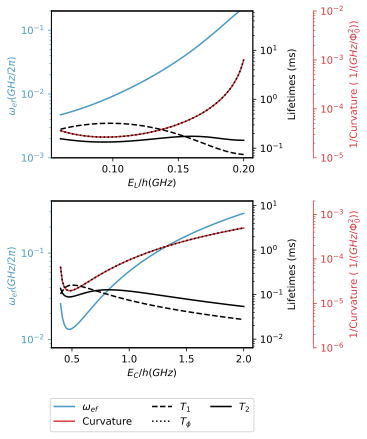

In [95]:
fig = plt.figure(figsize=(5, 6))
height =0.34
left = 0.15
right = 0.71
gs0 = gridspec.GridSpec(1, 1, left= left, right=right, bottom=0.2, top=0.2+ height)
gs1= gridspec.GridSpec(1, 1, left=left, right=right, bottom=0.2+ height + 0.1, top=0.2+ height + 0.1 + height)
ax_freq_EC = plt.subplot(gs0[0])
ax_freq_EL = fig.add_subplot(gs1[0])
curvature_ax_shift = 1.3

def plot_ef_against_EC(ax_freq_EC):
    import pickle
    filename = "ef_against_EC.pkl"
    EC_arr = np.linspace(0.4,2,100)
    with open(filename, 'rb') as f:
        phi_element_arr, curvature_arr, frequency_arr = pickle.load(f)
    phi_element_arr = np.array(phi_element_arr)
    frequency_arr = np.array(frequency_arr)
    curvature_arr = np.array(curvature_arr)
    Q_cap = 1e5
    one_over_f_flux_noise_amplitude = 1e-5
    temp_in_mK=20
    dielectric_lifetime = 1 / (np.abs(phi_element_arr)**2 * diel_spectral_density(frequency_arr, EC_arr,temp_in_mK,Q_cap)) / 1e6
    one_over_f_loss_lifetime = 1 / (np.abs(phi_element_arr)**2 * one_over_f_spectral_density(frequency_arr, EL,one_over_f_flux_noise_amplitude ))  / 1e6
    dephasing_lifetime = T_phi(curvature_arr, one_over_f_flux_noise_amplitude) / 1e6
    T1 =1/(1/dielectric_lifetime + 1/one_over_f_loss_lifetime)
    T2 = 1/ (1/(2*T1) + 1/dephasing_lifetime)


    ax_freq_EC.plot(EC_arr,frequency_arr/2/np.pi,color='#4999c3')
    ax_freq_EC.tick_params(axis='y', colors=ax_freq_EC.get_lines()[0].get_color())
    ax_freq_EC.yaxis.label.set_color(ax_freq_EC.get_lines()[0].get_color())
    ax_freq_EC.tick_params(axis='y', which='both', colors=ax_freq_EC.get_lines()[0].get_color())
    ax_freq_EC.spines['left'].set_color(ax_freq_EC.get_lines()[0].get_color())

    ax_freq_EC.set_ylim(8e-3,4e-1)
    ax_freq_EC.set_xlabel(rf"$E_C/h (GHz)$")
    ax_freq_EC.set_ylabel(rf"$\omega_{{ef}} (GHz/2\pi)$ ")
    ax_freq_EC.set_yscale('log')

    ax_curvature_EC = ax_freq_EC.twinx()
    ax_curvature_EC.spines.right.set_position(("axes", curvature_ax_shift))
    ax_curvature_EC.plot(EC_arr,1/curvature_arr,color='#d5373d')
    ax_curvature_EC.yaxis.label.set_color(ax_curvature_EC.get_lines()[0].get_color())
    ax_curvature_EC.tick_params(axis='y', which='both', colors=ax_curvature_EC.get_lines()[0].get_color())
    ax_curvature_EC.spines['right'].set_color(ax_curvature_EC.get_lines()[0].get_color())
    ax_curvature_EC.set_ylabel(r'1/Curvature ( $1/(GHz/\Phi_0^2)$)') 
    ax_curvature_EC.set_ylim(1e-6,2e-3)
    ax_curvature_EC.set_yscale('log')


    ax_lifetime_EC = ax_freq_EC.twinx()
    ax_lifetime_EC.plot([],[],color=ax_freq_EC.get_lines()[0].get_color(),label = rf"$\omega_{{ef}}$")
    ax_lifetime_EC.plot([],[],color=ax_curvature_EC.get_lines()[0].get_color(),label = r'Curvature')
    ax_lifetime_EC.plot(EC_arr,T1,label = r'$T_{{1}}$',color='black',linestyle='--')
    # ax_lifetime.plot(EC_arr,one_over_f_loss_lifetime,label = r'$T_{{1/f}}$',color='black',linestyle=':')
    ax_lifetime_EC.plot(EC_arr,dephasing_lifetime,label = r'$T_{{\phi}}$',color='black',linestyle=':')
    ax_lifetime_EC.plot(EC_arr,T2,label = r'$T_{{2}}$',color='black',linestyle='-')
    ax_lifetime_EC.set_ylabel(r'Lifetimes (ms)')
    ax_lifetime_EC.set_yscale('log')
    # ax_lifetime_EC.legend(loc='center right')
    dephasing_min = dephasing_lifetime.min()
    dephasing_max = dephasing_lifetime.max()
    curvature_y_data = ax_curvature_EC.get_lines()[0].get_ydata()
    curvature_y_min = curvature_y_data.min()
    curvature_y_max = curvature_y_data.max()
    curvature_ylim_min = ax_curvature_EC.get_ylim()[0]
    curvature_ylim_max = ax_curvature_EC.get_ylim()[1]
    dp_length_log_scale = abs(np.log10(dephasing_max) - np.log10(dephasing_min))
    curvature_ylim_length_log_scale = abs(np.log10(curvature_ylim_max) - np.log10(curvature_ylim_min))
    curvature_y_length_log_scale = abs(np.log10(curvature_y_max) - np.log10(curvature_y_min))
    dq_ylim_length_log_scale = dp_length_log_scale * curvature_ylim_length_log_scale / curvature_y_length_log_scale
    curvature_ymin_ratio = np.abs(np.log10(curvature_y_min)-np.log10(curvature_ylim_min))  / np.abs(np.log10(curvature_ylim_max)-np.log10(curvature_ylim_min))
    dq_ylim_min_log_scale = np.log10(dephasing_min) - dq_ylim_length_log_scale * curvature_ymin_ratio
    dq_ylim_max_log_scale = dq_ylim_min_log_scale + dq_ylim_length_log_scale
    dq_ylim_min = 10**dq_ylim_min_log_scale
    dq_ylim_max = 10**dq_ylim_max_log_scale
    ax_lifetime_EC.set_ylim(dq_ylim_min, dq_ylim_max)
    ax_lifetime_EC.set_yscale('log')
plot_ef_against_EC(ax_freq_EC)

def plot_ef_against_EL(ax_freq_EL):
    import pickle
    filename = "ef_against_EL.pkl"
    EL_arr = np.linspace(0.06,0.2,100)
    with open(filename, 'rb') as f:
        phi_element_arr, curvature_arr, frequency_arr = pickle.load(f)
    phi_element_arr = np.array(phi_element_arr)
    frequency_arr = np.array(frequency_arr)
    curvature_arr = np.array(curvature_arr)
    Q_cap = 1e5
    one_over_f_flux_noise_amplitude = 1e-5
    temp_in_mK=20
    dielectric_lifetime = 1 / (np.abs(phi_element_arr)**2 * diel_spectral_density(frequency_arr, EC_arr,temp_in_mK,Q_cap)) / 1e6
    one_over_f_loss_lifetime = 1 / (np.abs(phi_element_arr)**2 * one_over_f_spectral_density(frequency_arr, EL,one_over_f_flux_noise_amplitude ))  / 1e6
    dephasing_lifetime = T_phi(curvature_arr, one_over_f_flux_noise_amplitude) / 1e6
    T1 =1/(1/dielectric_lifetime + 1/one_over_f_loss_lifetime)
    T2 = 1/ (1/(2*T1) + 1/dephasing_lifetime)

    
    ax_freq_EL.plot(EL_arr,frequency_arr/2/np.pi,color='#4999c3')
    ax_freq_EL.tick_params(axis='y', colors=ax_freq_EL.get_lines()[0].get_color())
    ax_freq_EL.yaxis.label.set_color(ax_freq_EL.get_lines()[0].get_color())
    ax_freq_EL.tick_params(axis='y', which='both', colors=ax_freq_EL.get_lines()[0].get_color())
    ax_freq_EL.spines['left'].set_color(ax_freq_EL.get_lines()[0].get_color())

    ax_freq_EL.set_ylim(1e-3,2e-1)
    ax_freq_EL.set_xlabel(rf"$E_L/h (GHz)$")
    ax_freq_EL.set_ylabel(rf"$\omega_{{ef}} (GHz/2\pi)$ ")
    ax_freq_EL.set_yscale('log')

    ax_curvature_EL = ax_freq_EL.twinx()
    ax_curvature_EL.spines.right.set_position(("axes", curvature_ax_shift))
    ax_curvature_EL.plot(EL_arr,1/curvature_arr,color='#d5373d')
    ax_curvature_EL.yaxis.label.set_color(ax_curvature_EL.get_lines()[0].get_color())
    ax_curvature_EL.tick_params(axis='y', which='both', colors=ax_curvature_EL.get_lines()[0].get_color())
    ax_curvature_EL.spines['right'].set_color(ax_curvature_EL.get_lines()[0].get_color())
    ax_curvature_EL.set_ylabel(r'1/Curvature ( $1/(GHz/\Phi_0^2)$)') 
    ax_curvature_EL.set_ylim(1e-5,1e-2)
    ax_curvature_EL.set_yscale('log')


    ax_lifetime_EL = ax_freq_EL.twinx()
    ax_lifetime_EL.plot([],[],color=ax_freq_EL.get_lines()[0].get_color(),label = rf"$\omega_{{ef}}$")
    ax_lifetime_EL.plot([],[],color=ax_curvature_EL.get_lines()[0].get_color(),label = r'Curvature')
    ax_lifetime_EL.plot(EL_arr,T1,label = r'$T_{{1}}$',color='black',linestyle='--')
    # ax_lifetime.plot(EL_arr,one_over_f_loss_lifetime,label = r'$T_{{1/f}}$',color='black',linestyle=':')
    ax_lifetime_EL.plot(EL_arr,dephasing_lifetime,label = r'$T_{{\phi}}$',color='black',linestyle=':')
    ax_lifetime_EL.plot(EL_arr,T2,label = r'$T_{{2}}$',color='black',linestyle='-')
    ax_lifetime_EL.set_ylabel(r'Lifetimes (ms)')
    ax_lifetime_EL.set_yscale('log')
    ax_lifetime_EL.legend(loc='lower center',bbox_to_anchor=(0.5, -1.9),ncol = 3)

    dephasing_min = dephasing_lifetime.min()
    dephasing_max = dephasing_lifetime.max()
    curvature_y_data = ax_curvature_EL.get_lines()[0].get_ydata()
    curvature_y_min = curvature_y_data.min()
    curvature_y_max = curvature_y_data.max()
    curvature_ylim_min = ax_curvature_EL.get_ylim()[0]
    curvature_ylim_max = ax_curvature_EL.get_ylim()[1]
    dp_length_log_scale = abs(np.log10(dephasing_max) - np.log10(dephasing_min))
    curvature_ylim_length_log_scale = abs(np.log10(curvature_ylim_max) - np.log10(curvature_ylim_min))
    curvature_y_length_log_scale = abs(np.log10(curvature_y_max) - np.log10(curvature_y_min))
    dq_ylim_length_log_scale = dp_length_log_scale * curvature_ylim_length_log_scale / curvature_y_length_log_scale
    curvature_ymin_ratio = np.abs(np.log10(curvature_y_min)-np.log10(curvature_ylim_min))  / np.abs(np.log10(curvature_ylim_max)-np.log10(curvature_ylim_min))
    dq_ylim_min_log_scale = np.log10(dephasing_min) - dq_ylim_length_log_scale * curvature_ymin_ratio
    dq_ylim_max_log_scale = dq_ylim_min_log_scale + dq_ylim_length_log_scale
    dq_ylim_min = 10**dq_ylim_min_log_scale
    dq_ylim_max = 10**dq_ylim_max_log_scale
    ax_lifetime_EL.set_ylim(dq_ylim_min, dq_ylim_max)
    ax_lifetime_EL.set_yscale('log')
plot_ef_against_EL(ax_freq_EL)
    
fig.savefig('ef_against_EC.pdf')
